In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [8]:

# Parameters
STOCKS = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN','NFLX']  # List of stock symbols to train on
PREDICTION_DAYS = 60  # Number of days of historical data to use as input
PREDICTION_DAYS_AHEAD = 5  # Number of days to predict in advance
EPOCHS = 20  # Number of training epochs
BATCH_SIZE = 32  # Batch size for training
TRAIN_SPLIT = 0.8  # Split ratio for training data
STOCK_FOR_VALIDATION = 'AAPL'  # Stock to use for validation plot


In [ ]:

# Function to load stock data from Yahoo Finance
def load_data(stock_symbol):
    data = yf.download(stock_symbol, start="2010-01-01", end="2023-01-01")
    return data['Close'].values.reshape(-1, 1)  # Use closing price

# Function to normalize data using min-max scaling with numpy
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

# Function to denormalize data
def denormalize_data(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Function to preprocess data with moving average and variable prediction days
def preprocess_data_with_moving_average(stock_data, stock_id, moving_avg_window=5):
    # Apply moving average to smooth data
    stock_data_smoothed = pd.Series(stock_data.flatten()).rolling(window=moving_avg_window, min_periods=1).mean().values.reshape(-1, 1)
    
    # Normalize the smoothed data
    normalized_data, min_val, max_val = normalize_data(stock_data_smoothed)
    
    x_train, y_train = [], []
    for i in range(PREDICTION_DAYS, len(normalized_data) - PREDICTION_DAYS_AHEAD + 1):
        # Create input sequence for LSTM (PREDICTION_DAYS days of smoothed data)
        sequence = np.column_stack((normalized_data[i - PREDICTION_DAYS:i, 0], 
                                    np.full((PREDICTION_DAYS, 1), stock_id)))
        x_train.append(sequence)
        
        # Collect next PREDICTION_DAYS_AHEAD values as target output
        y_train.append(normalized_data[i:i + PREDICTION_DAYS_AHEAD, 0])
    
    return np.array(x_train), np.array(y_train), min_val, max_val


# Function to build the LSTM model with variable output days
def build_model_with_days_ahead():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(PREDICTION_DAYS, 2)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=PREDICTION_DAYS_AHEAD))  # Output layer now predicts multiple days
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:

# Main execution: preprocess data for each stock and concatenate
all_x_train, all_y_train, min_vals, max_vals = [], [], [], []
for stock_id, stock in enumerate(STOCKS):
    stock_data = load_data(stock)
    x_train, y_train, min_val, max_val = preprocess_data_with_moving_average(stock_data, stock_id)
    all_x_train.append(x_train)
    all_y_train.append(y_train)
    min_vals.append(min_val)
    max_vals.append(max_val)

# Combine training data from all stocks
x_train_combined = np.concatenate(all_x_train)
y_train_combined = np.concatenate(all_y_train)

# Build and train the model
model = build_model_with_days_ahead()
model.fit(x_train_combined, y_train_combined, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Validation Section
stock_data = load_data(STOCK_FOR_VALIDATION)
normalized_data, min_val, max_val = normalize_data(stock_data)

# Split data into training and validation sets
split_index = int(TRAIN_SPLIT * len(normalized_data))
train_data = normalized_data[:split_index]
validation_data = normalized_data[split_index - PREDICTION_DAYS:]

# Prepare training data
x_train, y_train = [], []
for i in range(PREDICTION_DAYS, len(train_data) - PREDICTION_DAYS_AHEAD + 1):
    sequence = np.column_stack((train_data[i - PREDICTION_DAYS:i, 0], np.full((PREDICTION_DAYS, 1), STOCKS.index(STOCK_FOR_VALIDATION))))
    x_train.append(sequence)
    y_train.append(train_data[i:i + PREDICTION_DAYS_AHEAD, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Prepare validation data
x_val, y_val = [], []
for i in range(PREDICTION_DAYS, len(validation_data) - PREDICTION_DAYS_AHEAD + 1):
    sequence = np.column_stack((validation_data[i - PREDICTION_DAYS:i, 0], np.full((PREDICTION_DAYS, 1), STOCKS.index(STOCK_FOR_VALIDATION))))
    x_val.append(sequence)
    y_val.append(validation_data[i:i + PREDICTION_DAYS_AHEAD, 0])

x_val, y_val = np.array(x_val), np.array(y_val)

# Retrain the model for the validation stock's specific data
model = build_model_with_days_ahead()
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Make predictions on the validation data
predictions = model.predict(x_val)
predicted_prices = denormalize_data(predictions, min_val, max_val)  # Convert predictions to original scale
real_prices = denormalize_data(y_val, min_val, max_val)  # Convert true values to original scale



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\danny\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0178
Epoch 2/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0025
Epoch 3/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0018
Epoch 4/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0013
Epoch 5/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0012
Epoch 6/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0011
Epoch 7/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.8742e-04
Epoch 8/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.3449e-04
Epoch 9/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.0766e-04
Epoch 10/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 8.2630e-04
Epoch 11/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.0509e-04
Epoch 12/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 8.4353e-04
Epoch 13/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 8.0485e-04
Epoch 14/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3900e-04

[*********************100%***********************]  1 of 1 completed

Epoch 1/20



C:\Users\danny\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0051
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5743e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8767e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9801e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9251e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5515e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.1266e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4196e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6200e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1959e-04
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0490e-04
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2249e-04
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0989e-04
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9179e-04
Epoch 15/20
80/80 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed


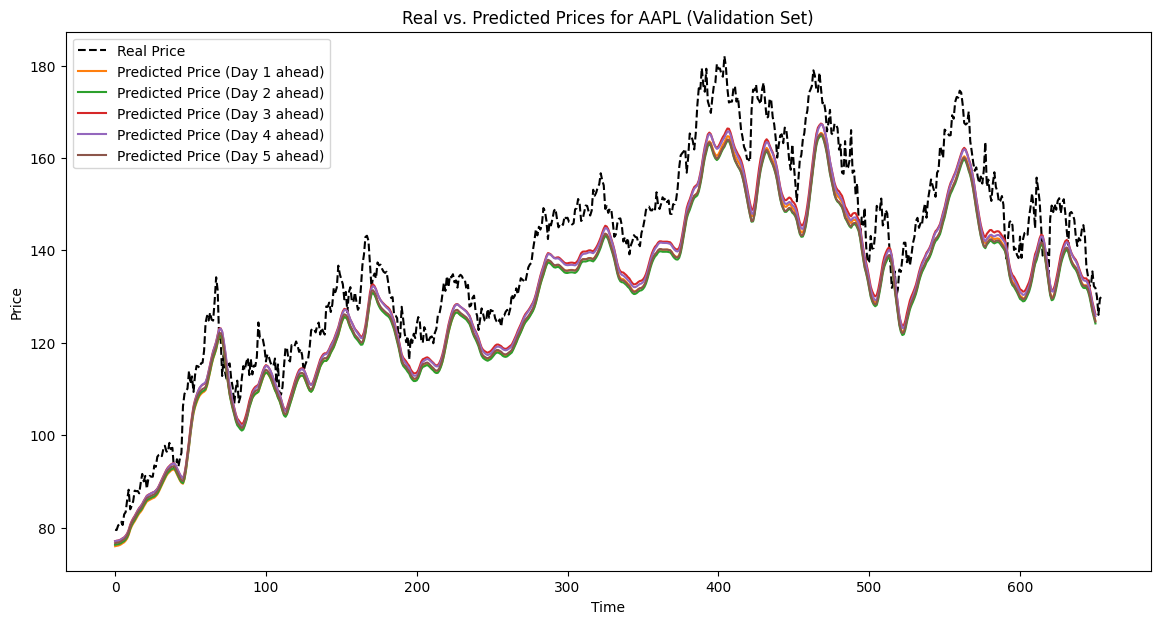

In [11]:
# Load real closing prices for the validation period
real_prices_data = yf.download(STOCK_FOR_VALIDATION, start="2010-01-01", end="2023-01-01")['Close'].values
real_prices_data = real_prices_data[split_index:]  # Use the validation portion only

# Denormalize real prices for plot consistency
real_prices_plot = denormalize_data(real_prices_data.reshape(-1, 1), min_val, max_val)

# Plot the results for the validation portion
plt.figure(figsize=(14, 7))

# Plot the real prices directly
plt.plot(real_prices_data, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day
for day in range(PREDICTION_DAYS_AHEAD):
    plt.plot(predicted_prices[:, day], label=f'Predicted Price (Day {day + 1} ahead)', color=f'C{day + 1}')

plt.title(f"Real vs. Predicted Prices for {STOCK_FOR_VALIDATION} (Validation Set)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()